In [437]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

import pandas as pd
from torch.utils.data import Dataset

from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import torch.autograd as autograd

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from kneed import KneeLocator

import scipy.ndimage
from scipy.signal import savgol_filter

torch.manual_seed(8)

In [419]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__() ## importing class from super
        self.model = nn.Sequential(
            nn.Linear(1050, 512), ## Note this is because there is 1050 inputs
            #nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2), #increased size for first layer
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            #nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2), #Uses ReLU activation
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            #nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1), #Last layer goes from 64 neurons to 1
            nn.Sigmoid(), ##using sigmoidal activation to create a single neuron output
        )
    def forward(self, x):
            output = self.model(x) #describes how the output of the model is calculated
            return output 

In [420]:
class Generator(nn.Module): # Inherits from the nn.Module
    def __init__(self, noise_dim = 100):
        super().__init__() ##allows you to create a nn architecture
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256), ## taking noise vector of 100 to have more diversity
            #nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            #nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2), # Leaky ReLU prevents overfitting, especially since the sample sets have been relatively small
            nn.Linear(512, 1024), 
            #nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1050),  # Output layer producing 1050 features
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        return output


In [421]:
class MOMADatasetHandler:
    #note this will only preprocess datasets that fit the same dimensions as the 2021 set
    def __init__(self, filepath, label_type):
        self.filepath = filepath
        self.label_type = label_type
        self.column_name = label_type + '_label'
        self.__training_data__ = pd.read_csv(filepath)
        self.__labels__ = None
        self.get_all_labels()


    def get_all_labels(self):
        column_name = f'{self.label_type}_label'
        self.__labels__ = self.__training_data__[column_name].unique().tolist()
        return self.__labels__
        

    def get_label_data(self, label):
        return self.__training_data__.loc[self.__training_data__[self.column_name] == label].copy()

        #features = training_data.loc[training_data[COLUMN] == CATEGORY_TYPE].copy()

    def get_all_labels_data(self):
        data_array = []
        for label in self.__labels__:
            data_array.append(self.__training_data__[label].copy())
            #print(self.__training_data__[label].head())

        return data_array

    def get_dataframe():

        return self.__training_data__

    def get_dataframe_diagnostic():
        return

        ## The plan is to try to store everything in an array of things
        
        #we are not training on any empty sets
        """
        if training_data.loc[training_data[COLUMN] == sample_label].empty:
            continue
        if training_data.loc[training_data[COLUMN] == sample_label].shape[0] < 512:
            not_enough.append((sample_label,training_data.loc[training_data[COLUMN] == sample_label].shape[0]))
            continue
       
        curr = training_data.loc[training_data[COLUMN] == sample_label].copy()
        print(sample_label, curr.shape)
        """
    def recommend_k_means(features):

        features = features.copy()
        
        features.drop(features.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
        features.drop(features.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
        features = features.drop(columns = ['USID'])
        WCSS=[]
        I = range(1, 20)
        
        for i in I:
          kmeans=KMeans(n_clusters=i,init='k-means++')
          kmeans.fit(features)
          WCSS.append(kmeans.inertia_)
        #print(WCSS)
        
        
        plt.plot(range(1,20),WCSS)
        
        kneedle = KneeLocator(I, WCSS, curve='convex', direction='decreasing')
        best_k = kneedle.elbow
        print(f"elbow at {best_k}")

    
    def divide_k_clusters(features, num_clusters):
        real_set = features.copy()
        features.drop(features.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
        features.drop(features.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
        features = features.drop(columns = ['USID'])
        
        kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++')
        kmeans.fit(features)

        cluster_centers = kmeans.cluster_centers_
        labels = kmeans.labels_


        real_set['Cluster'] = labels

        # Split the data into separate clusters
        clusters = []
        for cluster in range(num_clusters):
            clusters.append(real_set[real_set['Cluster'] == cluster])
            print(f"Cluster {cluster} has {len(clusters[cluster])} scans")
            clusters[-1] = clusters[-1].drop(columns = ['Cluster'])
        
        return clusters



In [428]:
class GANDataHandler:
    
    
    def __init__(self, generator_path = None, discriminator_path = None, features = None, batch_size = 128, lr = .001):
        
        
        def load_models(generator_path, discriminator_path):
            # Initialize the models
            generator = Generator()
            discriminator = Discriminator()
    
            # Load the state dictionaries
            generator.load_state_dict(torch.load(generator_path))
            discriminator.load_state_dict(torch.load(discriminator_path))

            return generator, discriminator
        
        
        if generator_path is not None and discriminator_path is not None and features is not None:
            self.generator, self.discriminator = load_models(generator_path, discriminator_path)
            self.features = features

        elif features is not None and generator_path is None and discriminator_path is None:
            self.features = features # MS Data
            self.generator = None
            self.discriminator = None

        
        self.scaler = MinMaxScaler() # Scaler. Used to fit transform data for the GANS and inverse transform to transform it back to GANS "size"
        self.batch_size = batch_size # # of samples being input at a time
        self.lr = lr # Learning Rate of the GANS

        ## Preprocessing Variables ##
        # Real Data used for training #
        self.real_data = None 
        self.real_labels = None
        self.real_set = None
        self.real_data_loader = None  # Dataloader to be used in training
        self.USIDs = None # USIDS will be merged later
        self.metadata = None
        
        ## Training Metrics to be Displayed by Classification Report ##
        # Average Loss over all training 
        self.avg_loss_g = None
        self.avg_loss_d = None
        # Number of Epochs trained on
        self.num_epochs_trained = 0
        # Average Accuracy of the Discriminator
        self.avg_disc_acc = None
        self.avg_gen_acc = None

        #cluster
        self.clusters = None


    
        

  
    """ preprocess_data()
    Preprocesses the features data by scaling and creates a DataLoader for use in model training or evaluation. Saves USIDS and Meta Data to be merged later.

    Steps:
    1. Scale the feature data using the scaler's fit_transform method.
    2. Generate labels for the real data.
    3. Create a dataset by zipping together the scaled data and the corresponding labels.
    4. Initialize a DataLoader with the created dataset, setting the batch size and shuffling the data.
    
    This method is used after GANS is created;

    test = GANDataHandler(ms_data)
    test.preprocess_data
    
    """
    def data_load(self, features):
        ## Preprocess data to be trained
        num_rows_to_drop = features.shape[0] % self.batch_size
        # Get the index of the rows to drop
        rows_to_drop = features.tail(num_rows_to_drop).index
        # Drop the rows
        features = features.drop(rows_to_drop)
        
        self.real_data = self.scaler.fit_transform(features)
        real_data_length = len(self.real_data)
        self.real_labels = torch.zeros(real_data_length)

        real_set = [ ## Zipping together labels and data to be used later
            (self.real_data[i], self.real_labels[i]) for i in range(real_data_length)
        ]
        
        self.real_data_loader = torch.utils.data.DataLoader(
            real_set, batch_size = self.batch_size, shuffle = True
        ) 

    
    def augment_spectrum(self, noise_level=0.01, shift_level=0.01, scale_factor_range=(0.9, 1.1), drop_probability=0.05):
        ms_data_aug = self.features.copy()
        print(ms_data_aug.head())
        # Apply noise
        ms_data_aug += noise_level * np.random.normal(size=self.features.shape)
    
        # Apply peak shift
        #ms_data_aug[:, 0] += shift_level * np.random.normal(size=self.features[:, 0].shape)
    
        # Apply intensity scaling
        scale_factor = np.random.uniform(*scale_factor_range)
        ms_data_aug[:, 1] *= scale_factor
    
        # Random peak dropping
        drop_mask = np.random.rand(self.features.shape[0]) < drop_probability
        ms_data_aug[drop_mask, 1] = 0
    
        return ms_data_aug

        
        
        
    def preprocess_data(self, augment = False):
        
        self.metadata = self.features.loc[:,'Laser_Energy':'formationprocess_label']
        self.features.drop(self.features.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
        self.features.drop(self.features.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
        self.USIDs = self.features['USID'].copy()
        self.features = self.features.drop(columns = ['USID'])

        if augment:
            new_data = self.augment_spectrum()
            self.features = pd.concat(self.features, new_data)

        self.data_load(self.features)

        
    
        
    """ display_features()
    Displays a graph of the feature data for a specified entry.

    This method plots the mass spectrometry data for a given entry, showing the intensity against the m/z (mass/charge ratio).

    Use:
    print(test.head()) #to find ids to input
    test.display_features(test_id)
    
    """
    def display_features(self, id):
        #entry = self.features[] ##Graphing of what our data should look like!
        print(self.features.head())
        entry = self.features.loc[id]
        plt.figure(figsize=(12, 6))
        plt.plot(entry)
        plt.title('Mass Spectrometry Data - 50th Entry')
        plt.xlabel('m/z (mass/charge ratio)')
        plt.ylabel('Intensity')
        plt.xticks(ticks=range(0, len(entry), 200))  # Show every 50th label

        plt.show()
    
    """ setup_optimizers()
    Sets up the loss function and optimizers for the discriminator and generator models.

    This method initializes the binary cross-entropy loss function and the Adam optimizers for both the discriminator and generator. 
    The learning rate for the generator's optimizer is set to be twice that of the discriminator's.

    Note: This is done within the train_model method, so this will not be needed to be called by the user
    """
    def setup_optimizers(self, discriminator, generator):
        loss_function = nn.BCELoss()
        optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = self.lr) ## Adam is the name of the optimizer we will use for the discriminator and generator
        optimizer_g = torch.optim.Adam(generator.parameters(), lr = self.lr * 2)

        return loss_function, optimizer_d, optimizer_g

    
    """ train_model()
    Trains the discriminator and generator models over a specified number of epochs.

    This method initializes the discriminator and generator models, sets up the optimizers and loss function,
    and trains the model.

    This method also keeps track of batch accuracy and other metrics to be displayed later
    
    Note: This method will be called by the user after creating the GANS and preprocessing the data
    """
    def train_model(self, num_epochs):
        discriminator = Discriminator()
        generator = Generator()
        loss_function, optimizer_d, optimizer_g = self.setup_optimizers(discriminator, generator)

        #Reset Batch Loss
        self.avg_loss_g, self.avg_loss_d = None, None
        self.avg_disc_acc, self.avg_gen_acc = None, None
        # Number of Epochs trained on
        self.num_epochs_trained = 0

        for epoch in range(num_epochs):

            NOISE_DIM = 100

            total_loss_d = 0
            total_loss_g = 0

            total_correct_d = 0
            total_samples_d = 0
            
            for n, (real_samples, _) in enumerate(self.real_data_loader):
                
                fake_labels = torch.zeros((self.batch_size, 1))
                real_labels = torch.ones((self.batch_size, 1))
                
                latent_space_samples = torch.randn((self.batch_size, NOISE_DIM))
                generated_samples = generator(latent_space_samples)
        
                all_samples = torch.cat((real_samples.to(torch.float32) , generated_samples.to(torch.float32)))
                all_sample_labels = torch.cat(
                    (real_labels, fake_labels)
                )
                all_sample_labels = all_sample_labels
                
                
                #Train the discriminator
                discriminator.zero_grad() # clear gradients at each step to avoid accumulation
                output_discriminator = discriminator(all_samples) #calculate output of the batch
                #print(output_discriminator.shape, all_sample_labels.shape)
                loss_discriminator = loss_function(
                    input = output_discriminator.view(-1), target = all_sample_labels.view(-1) ##loss function
                )
                loss_discriminator.backward() #calculate gradients to update weights (gradient descent)
                optimizer_d.step() #optimizer_discriminator.step()

                #calculate optimizer accuracy
                predicted_labels = (output_discriminator > 0.5).float()
                total_correct_d += (predicted_labels == all_sample_labels).sum().item()
                total_samples_d += all_sample_labels.size(0)
                
                #Time to train the generator
                
                #data for generator
                latent_space_samples = torch.randn((self.batch_size, NOISE_DIM))
        
                #Training the generator
                generator.zero_grad()
                generated_samples = generator(latent_space_samples)
                output_discriminator_generated = discriminator(generated_samples)
                loss_generator = loss_function(
                    output_discriminator_generated, real_labels
                )
                loss_generator.backward()
                optimizer_g.step()

                total_loss_d += loss_discriminator
                total_loss_g += loss_generator
                

                 # Show loss
                if epoch % 10 == 0 and n == 5:
                    print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                    print(f"Epoch: {epoch} Loss G.: {loss_generator}")

            #save generator and discriminator
            self.generator = generator
            self.discriminator = discriminator
            
            #Update Loss with updated batch loss
            batch_len = len(self.real_data_loader)
            batch_loss_g = total_loss_g / batch_len
            batch_loss_d = total_loss_d / batch_len

            #Update Avg Discriminator and Generator Accuracy for the current batch:
            avg_disc_acc = total_correct_d / total_samples_d
            
            fake_labels_for_gen_acc = torch.ones((self.batch_size, 1))
            output_discriminator_generated = discriminator(generated_samples)
            gen_pred_labels = (output_discriminator_generated > 0.5).float()
            gen_acc = (gen_pred_labels == fake_labels_for_gen_acc).sum().item() / self.batch_size

            self.num_epochs_trained += 1
            
            if not self.avg_loss_g and not self.avg_loss_d:
                self.avg_loss_g = batch_loss_g
                self.avg_loss_d = batch_loss_d
                self.avg_disc_acc = avg_disc_acc
                self.avg_gen_acc = gen_acc
                
            else:
                self.avg_loss_g = (batch_loss_g + (self.avg_loss_g * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_loss_d = (batch_loss_d + (self.avg_loss_d * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_disc_acc = (avg_disc_acc + (self.avg_disc_acc * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_gen_acc = (gen_acc + (self.avg_gen_acc * (self.num_epochs_trained - 1)))/self.num_epochs_trained


    """ generate_samples()
    Generates synthetic samples using the trained generator model and saves them to a CSV file.

    This method generates samples from the latent space, transforms them back to the original scale,
    applies a moving average smoothing, and saves the results to a CSV file along with metadata.
    """
    def generate_samples(self, num_samples, num_batches = 1, smooth_filter = 'no_smooth'):
        filter_types = {'gauss', 'rolling', 'savitsky', 'no_smooth'}

        def moving_average(df, window_size):
            return df.rolling(window=window_size).mean()

        def gauss(df):
            return pd.DataFrame(scipy.ndimage.gaussian_filter(df.values, sigma=1), columns = df.columns) 

        def savitsky(df):
            POLYORDER = 3
            WINDOW_LENGTH = 10

            data_np = df.values
            smoothed_data_np = savgol_filter(data_np, window_length=WINDOW_LENGTH, polyorder=POLYORDER, axis=0)
            smoothed_df = pd.DataFrame(smoothed_data_np, columns=df.columns)
            return smoothed_df

        noise_dim = 100
        for batch in range(num_batches):
            latent_space_samples = torch.randn(num_samples, noise_dim) #100 is number of samples to make
            generated_samples = self.generator(latent_space_samples)
            generated_samples = generated_samples.detach()
            generated_samples = self.scaler.inverse_transform(generated_samples)
            graphed = generated_samples.clip(min = 0)
            
            
    
            # Example usage
            DF = pd.DataFrame(graphed)
            if smooth_filter in filter_types:
                if smooth_filter == 'rolling':
                    DF = moving_average(DF, window_size=5)
                elif smooth_filter == 'gauss':
                    DF = gauss(DF)
                elif smooth_filter == 'savitsky':
                    DF = savitsky(DF)
            else:
                smooth_filter = 'no_smooth'
    
        
            DF.insert(0, 'USID', self.USIDs)
            DF['USID'] = 'G' + DF['USID'].astype(str)
                
            for col in self.metadata.columns:
                DF[col] = self.metadata[col]
        
            ## Note this will be updated in later iterations
            CATEGORY_TYPE = 'CsI'
    
            if not os.path.exists('./generated_samples'):
                os.makedirs('./generated_samples')

            if num_batches == 1:
                DF.to_csv(f"./generated_samples/{CATEGORY_TYPE}_samples_{smooth_filter}.csv")
            else:
                DF.to_csv(f"./generated_samples/{CATEGORY_TYPE}_samples_{smooth_filter}_batch_{batch}.csv")

    
        
        
        
        # Select a few spectra to plot
        num_spectra_to_plot = 4
        spectra_indices = [10] # Change these indices to plot different spectra
        
        plt.figure(figsize=(12, 6))
        
        for i in spectra_indices:
            plt.plot(graphed[i], label=f'Spectrum {i+1}')
        
        plt.title("Mass Spectra")
        plt.xlabel("Mass/Charge (m/z)")
        plt.ylabel("Intensity")
        plt.legend()
        plt.show()

    
    """ generate_classification_report()
    Generates and saves a classification report summarizing the training performance of the generator and discriminator models.

    This method prints the average generator and discriminator losses and accuracies, calculates the total number of samples trained,
    and saves these metrics to a CSV file.
    
    """
    def generate_classification_report(self, output_csv = 'classification_report.csv'):

        # Average Loss over all training 
        print(f"Average Generator Loss over {self.num_epochs_trained} Epochs: {self.avg_loss_g}")
        print(f"Average Discriminator Loss over {self.num_epochs_trained} Epochs: {self.avg_loss_d}")

        print(f"Average Generator Accuracy from the last train: {self.avg_gen_acc}")
        print(f"Average Discriminator Accuracy from the last train: {self.avg_disc_acc}")

        total_samples_trained = self.batch_size * self.num_epochs_trained

        with open(output_csv, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Metric', 'Value'])
                writer.writerow(['Average Generator Loss', self.avg_loss_g.item()])
                writer.writerow(['Average Discriminator Loss', self.avg_loss_d.item()])
                writer.writerow(['Average Generator Accuracy', self.avg_gen_acc])
                writer.writerow(['Average Discriminator Accuracy', self.avg_disc_acc])
                writer.writerow(['Total Samples Trained', total_samples_trained])
        
        print(f"Classification report saved to {output_csv}")
        # Average Accuracy of the Discriminator


    """ export_models()
    Exports the trained generator and discriminator models to the specified directory.

    This method saves the state dictionaries of the generator and discriminator models to the specified directory
    with filenames based on the given sample name.
    """
    def export_models(self, sample_name, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        generator_path = os.path.join(directory, f'{sample_name}_generator.pth')
        discriminator_path = os.path.join(directory, f'{sample_name}_discriminator.pth')
        
        torch.save(self.generator.state_dict(), generator_path)
        torch.save(self.discriminator.state_dict(), discriminator_path)
        
        print(f'Models saved in directory: {directory}')

    
    def display_feature_distribution(self):
        plt.figure(figsize=(12, 6))
        
        for row in self.features.index:
            plt.plot(self.features.loc[row])
        
        plt.title("Mass Spectra")
        plt.xlabel("Mass/Charge (m/z)")
        plt.ylabel("Intensity")
        plt.legend()
        plt.show()

## Load Data into the MOMA Dataset Handler, and extract labels to examine (example)

Pick a sample to examine. After, figure out k-means distribution of sample and decide how many clusters you want to divide the data into

elbow at 5
Cluster 0 has 613 scans
Cluster 1 has 812 scans


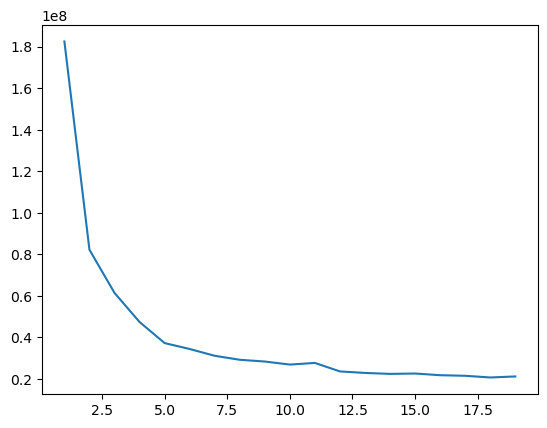

In [433]:
curr_sample = xina_data.get_label_data('Feldspar')
MOMADatasetHandler.recommend_k_means(curr_sample)
sample_clusters = MOMADatasetHandler.divide_k_clusters(curr_sample, 2)

Preprocess GAN for training, note, do not run multiple times because you will get an error (You cant preprocess more than once!)

In [434]:
cluster_0 = GANDataHandler(features = sample_clusters[0])
cluster_0.preprocess_data()

Display feature distribution of the current cluster

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


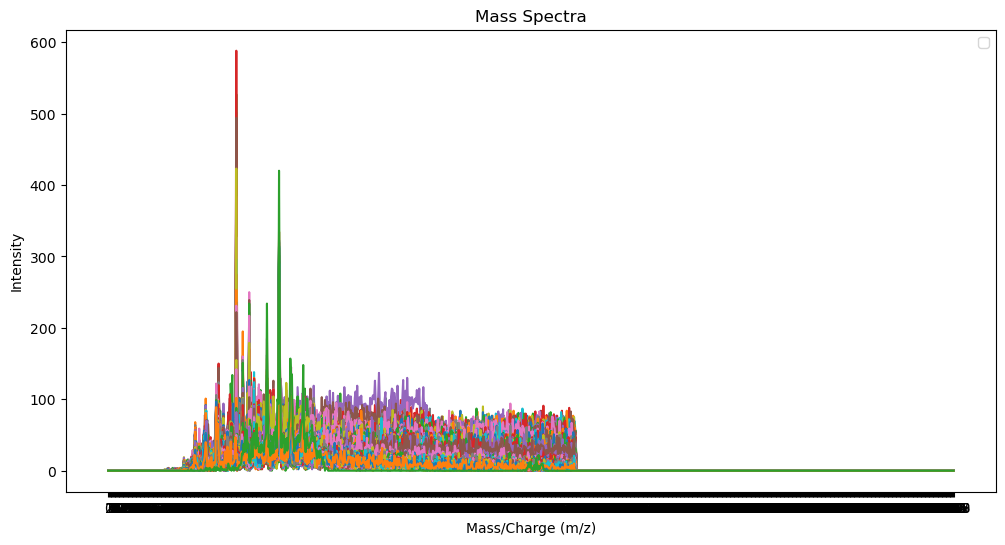

In [435]:
cluster_0.display_feature_distribution()

Create and generate samples

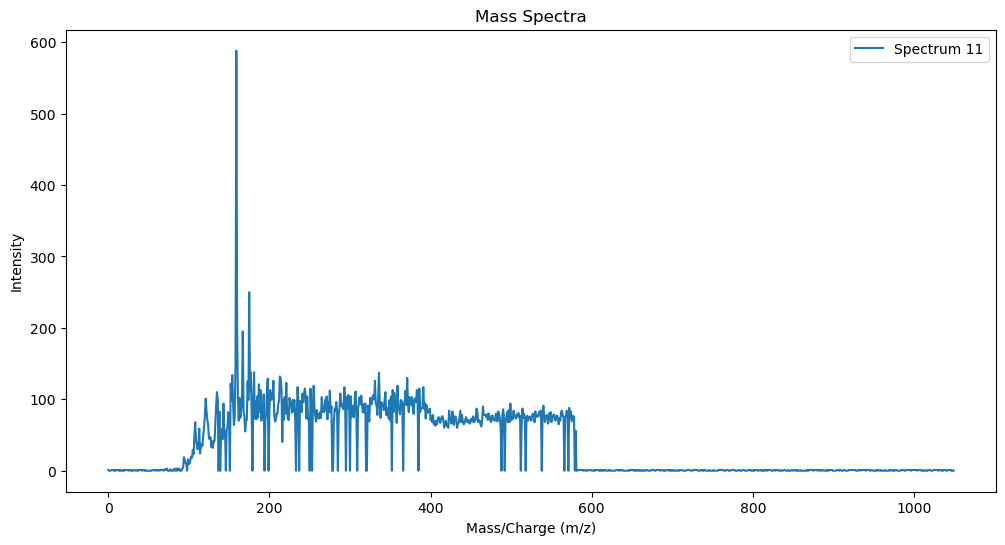

In [436]:
cluster_0.train_model(num_epochs = 50)
cluster_0.generate_samples(30)


Use this method to display a specific feature, to see a list of indices, input -1 as parameter

       0  1  2  3  4  5  6  7  8  9  ...  1040  1041  1042  1043  1044  1045  \
14809  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
14810  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
14811  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
14812  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
14813  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

       1046  1047  1048  1049  
14809     0     0     0     0  
14810     0     0     0     0  
14811     0     0     0     0  
14812     0     0     0     0  
14813     0     0     0     0  

[5 rows x 1050 columns]


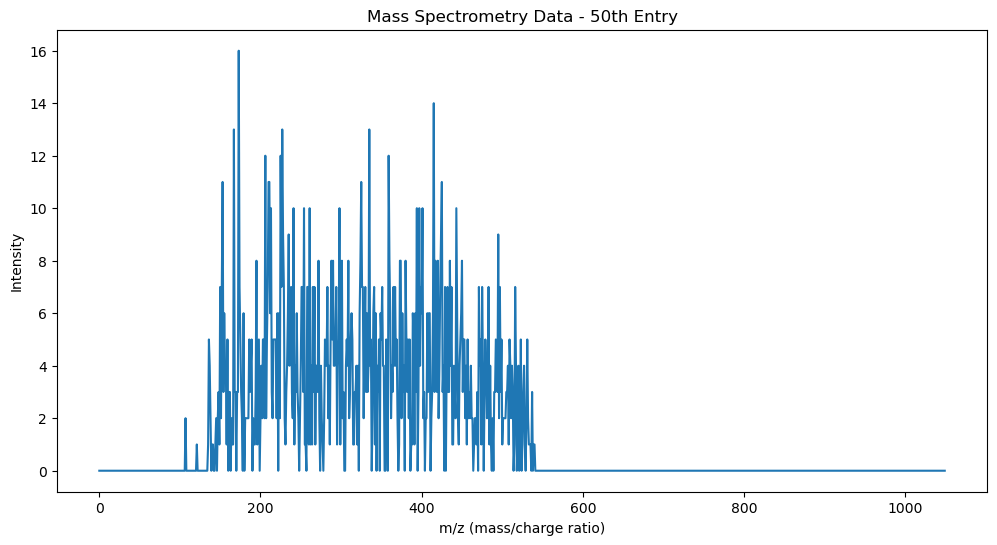

In [395]:
ygsp_0.display_features(14809)